In [32]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [33]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.16.1


## Prepare Dataset

In [34]:
# train_dataset_path = './dataset/dataset-raw-asli/train_preprocess.tsv'
# valid_dataset_path = './dataset/dataset-raw-asli/valid_preprocess.tsv'

train_dataset_path = '../Dataset/Training/Clean_train_data_nostem.csv'
# valid_dataset_path = './dataset-emosi/valid_preprocess.csv'

In [35]:
# train_df = pd.read_csv(train_dataset_path, sep='\t', header=None)
# valid_df = pd.read_csv(valid_dataset_path, sep='\t', header=None)

# train_df.columns = ['text', 'label']
# valid_df.columns = ['text', 'label']

train_df = pd.read_csv(train_dataset_path, sep=',', header=None, usecols=[1,2], skiprows=1)
# valid_df = pd.read_csv(valid_dataset_path, sep=',', header=None, usecols=[0,1], skiprows=1)

train_df.columns = ['tweet', 'label']
# valid_df.columns = ['label', 'tweet']

In [36]:
train_df.head(10)

,tweet,label
0,"['pagi', 'buat', 'emosi']",Anger
1,"['stabilitas', 'negara', 'memange', 'tahun', '...",Anger
2,"['emosi', 'terus', 'liat']",Anger
3,"['aib', 'bodoh', 'benar', 'kata', 'aib', 'munc...",Anger
4,"['kamu', 'menyebalkan', 'bodoh']",Anger
5,"['asli', 'malu', 'maluin', 'orang', 'indo', 't...",Anger
6,"['drama', 'abg', 'tolol']",Anger
7,"['emosi', 'sama', 'katla', 'kemarin', 'mana', ...",Anger
8,"['bangsat', 'tribute', 'no', 'bencana', 'no', ...",Anger
9,"['pergi', 'jauh', 'terus', 'teriak', 'nangis',...",Anger


In [37]:
train_df['label']

0       Anger
1       Anger
2       Anger
3       Anger
4       Anger
        ...  
7075      Sad
7076      Sad
7077      Sad
7078      Sad
7079      Sad
Name: label, Length: 7080, dtype: object

In [38]:
def get_label_idx(label):
    if label == 'Anger':
        return 0
    if label == 'Joy':
        return 1
    if label == 'Fear':
        return 2
    if label == "Love":
        return 3
    if label == "Sad":
        return 4
    if label == "Neutral":
        return 5

train_df['label'] = train_df['label'].apply(get_label_idx)
# valid_df['label'] = valid_df['label'].apply(get_label_idx)


In [39]:
unique_labels = train_df['label'].unique()
print(unique_labels)


[0 2 1 3 5 4]


In [40]:
train_df

,tweet,label
0,"['pagi', 'buat', 'emosi']",0
1,"['stabilitas', 'negara', 'memange', 'tahun', '...",0
2,"['emosi', 'terus', 'liat']",0
3,"['aib', 'bodoh', 'benar', 'kata', 'aib', 'munc...",0
4,"['kamu', 'menyebalkan', 'bodoh']",0
...,...,...
7075,"['pagi', 'seisi', 'semesta', 'sujud', 'zat', '...",4
7076,"['meski', 'engkau', 'pergi', 'meski', 'engkau'...",4
7077,"['biasa', 'kalah', 'tersakiti']",4
7078,"['apakabar', 'ku', 'baik', 'baik', 'sedang', '...",4


In [41]:
# filter dataset yang labelnya 0-4 aja
train_df = train_df[train_df['label'] < 6]
# valid_df = valid_df[valid_df['label'] < 5]

In [42]:
train_df['label'].value_counts()

label
5    2001
1    1275
0    1130
4    1003
2     911
3     760
Name: count, dtype: int64

In [43]:
# join list of token as single document string
import ast

def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])
train_df["preprocessed"] = train_df["tweet"].apply(join_text_list)
# valid_df["preprocessed"] = valid_df["tweet_tokens_no_stemming"].apply(join_text_list)

train_df["preprocessed"].head()

0                                      pagi buat emosi
1    stabilitas negara memange tahun negara aman ba...
2                                     emosi terus liat
3    aib bodoh benar kata aib muncul terlebih tinda...
4                               kamu menyebalkan bodoh
Name: preprocessed, dtype: object

## Generate Padded Sequence

In [44]:
# Parameters

vocab_size = 20000 #ukuran kosakata yang akan digunakan
max_length = 100 #panjang maksimal dari sebuah kalimat
embedding_dim = 8 #dimensi vektor embedding yang akan digunakan
trunc_type='post' #jika panjang kalimat melebihi max_length, potong bagian belakang kalimat
oov_tok = "<OOV>" #OOV (Out Of Vocabulary) token, jika suatu kata tidak ditemukan dalam kosakata

In [45]:
from sklearn.model_selection import train_test_split

# Bagi dataset menjadi data pelatihan dan data validasi
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state=42)

# Inisialisasi tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

# Generate word index dictionary untuk kalimat-kalimat pelatihan
tokenizer.fit_on_texts(train_df['preprocessed'])
word_index = tokenizer.word_index
print(word_index)

# Convert kalimat-kalimat pelatihan menjadi urutan kata
train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# Convert kalimat-kalimat validasi menjadi urutan kata
valid_sequences = tokenizer.texts_to_sequences(valid_df['preprocessed'])
valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)


{'<OOV>': 1, 'sekali': 2, 'suka': 3, 'kalau': 4, 'sama': 5, 'kamu': 6, 'sedih': 7, 'orang': 8, 'jadi': 9, 'sangat': 10, 'semangat': 11, 'mau': 12, 'takut': 13, 'apa': 14, 'terus': 15, 'jangan': 16, 'nya': 17, 'buat': 18, 'enak': 19, 'pagi': 20, 'tahu': 21, 'biasa': 22, 'marah': 23, 'banyak': 24, 'baik': 25, 'hari': 26, 'bodoh': 27, 'memang': 28, 'lebih': 29, 'bikin': 30, 'bahagia': 31, 'dulu': 32, 'tuh': 33, 'benar': 34, 'kabar': 35, 'si': 36, 'malu': 37, 'anak': 38, 'sayang': 39, 'pakai': 40, 'semua': 41, 'selalu': 42, 'kasih': 43, 'sepi': 44, 'cinta': 45, 'baru': 46, 'pas': 47, 'semoga': 48, 'sendiri': 49, 'cuma': 50, 'tak': 51, 'sekarang': 52, 'tetap': 53, 'wkwk': 54, 'bukan': 55, 'emosi': 56, 'kak': 57, 'kaget': 58, 'yaa': 59, 'teman': 60, 'punya': 61, 'padahal': 62, 'benci': 63, 'soalnya': 64, 'kecewa': 65, 'liat': 66, 'pernah': 67, 'kadang': 68, 'malah': 69, 'mirip': 70, 'biar': 71, 'ku': 72, 'tolol': 73, 'langsung': 74, 'senang': 75, 'diri': 76, 'gini': 77, 'i': 78, 'mana': 79, 

In [46]:
# ## Tokenization
# tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)

# # Generate word index dictionary for the training sentences
# tokenizer.fit_on_texts(train_df['preprocessed'])
# word_index = tokenizer.word_index
# print(word_index)

# # Convert the training sentences into word sequences
# train_sequences = tokenizer.texts_to_sequences(train_df['preprocessed'])
# train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)

# # Convert the validation sentences into word sequences
# valid_sequences = tokenizer.texts_to_sequences(valid_df['tweet'])
# valid_padded = pad_sequences(valid_sequences, maxlen=max_length, truncating=trunc_type)

In [47]:
# Split Dataset


In [48]:
# import pickle

# # Simpan tokenizer ke dalam file
# with open('tokenizer-3classes-no-stemming.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [49]:
print(train_padded[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0 1203   14
  192 2549]


## Word Embedding

In [50]:
from gensim.models import Word2Vec

sentences = [sentence.split() for sentence in train_df['preprocessed']]
w2v_model = Word2Vec(sentences, vector_size=8, window=5, min_count=5, workers=4)

In [51]:
# Create a weight matrix for the embedding layer
embedding_matrix = np.zeros((vocab_size, 8))
for word, i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]

In [52]:
# Mencari kata berdasarkan vektor tertentu
def find_word_by_vector(embedding_matrix, vector):
    for word, index in word_index.items():
        if np.array_equal(embedding_matrix[index], vector):
            return word, embedding_matrix[index]
    return None

# Contoh: Mencari kata untuk vektor embedding_matrix[3]
word = find_word_by_vector(embedding_matrix, embedding_matrix[1000])
print(word)

('mengalami', array([-0.21160834, -0.00730715,  0.23987329,  0.19480151,  0.15226671,
       -0.07303362,  0.61226791, -0.15513143]))


## Build and Compile Model

In [53]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 8, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), input_shape=(max_length,), trainable=False),
    # tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

c:\Users\TEMP\miniconda3\Lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 8)         │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100, 256)       │         2,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 100, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │        38,406 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 241,862 (944.77 KB)

 Trainable params: 81,862 (319.77 KB)

 Non-trainable params: 160,000 (625.00 KB)

In [54]:
# Looping untuk mendapatkan bobot dari setiap layer
for layer in model.layers:
    # Mengecek apakah layer memiliki bobot
    if layer.weights:
        print("Layer Name:", layer.name)
        # Mendapatkan bobot dan bias dari layer
        weights = layer.get_weights()
        for i, w in enumerate(weights):
            print("Weights Shape (Tensor {}):".format(i), w.shape)
            print("Weights (Tensor {}):".format(i))
            print(w)


Layer Name: embedding_1
Weights Shape (Tensor 0): (20000, 8)
Weights (Tensor 0):
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-1.1366546  -0.06152559  1.0490253  ... -0.9900292   3.0079372
  -0.20479234]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
Layer Name: dense_4
Weights Shape (Tensor 0): (8, 256)
Weights (Tensor 0):
[[-0.00307453  0.14202046  0.05585316 ...  0.11130506 -0.01917721
   0.04885751]
 [ 0.14730003 -0.1266663   0.04602481 ...  0.13709229  0.03379802
   0.06677428]
 [-0.07332161 -0.06427793 -0.11209612 ... -0.05468235  0.1046105
  -0.00845058]
 ...
 [-0.02166566 -0.13360718  0.14894795 ... -0.00228187  0.02542149
  -0.07925785]
 [-0.09806776  0.11254829  0.11798033 ...  0.06277825 -0.08429535

## Train Model

In [55]:
num_epochs = 100

history = model.fit(train_padded, train_df['label'], epochs=num_epochs, validation_data=(valid_padded, valid_df['label']), verbose=1)


Epoch 1/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.2822 - loss: 1.7451 - val_accuracy: 0.2719 - val_loss: 1.7291
Epoch 2/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.2870 - loss: 1.7036 - val_accuracy: 0.2888 - val_loss: 1.6879
Epoch 3/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3326 - loss: 1.6338 - val_accuracy: 0.3686 - val_loss: 1.6241
Epoch 4/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.3871 - loss: 1.5495 - val_accuracy: 0.3863 - val_loss: 1.5614
Epoch 5/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4130 - loss: 1.4948 - val_accuracy: 0.3849 - val_loss: 1.5456
Epoch 6/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4132 - loss: 1.4735 - val_accuracy: 0.3891 - val_loss: 1.5533
Epoch 7/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4241 - loss: 1.4552 - val_accuracy: 0.3905 - val_loss: 1.5238
Epoch 8/100
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.4325 - loss: 1.4313 - 

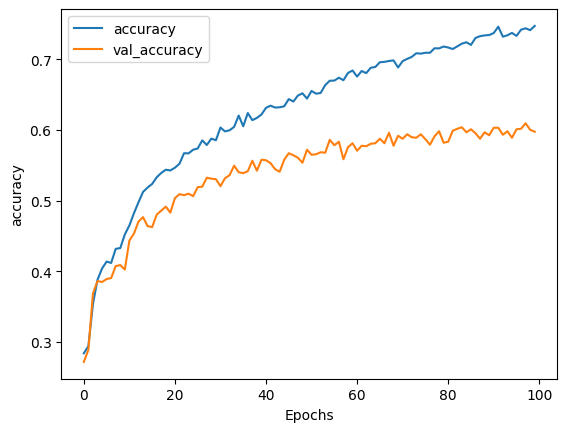

In [56]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")

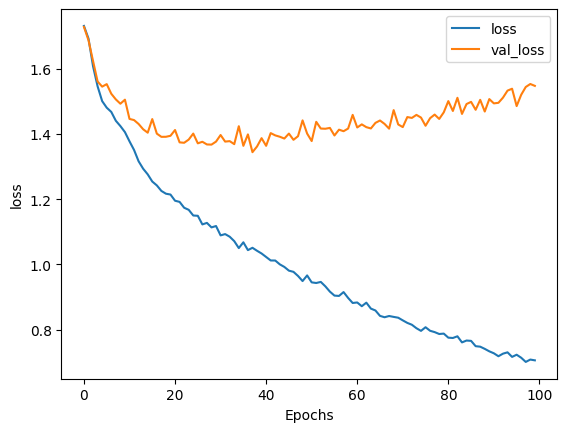

In [57]:
# Plot the training history
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "loss")

In [58]:
# saved model
model.save('model-5classes-no-stemming-ANN.h5')

In [59]:
## test model with predict one example sentence
sample_text = ["aduh gimana ya ini takut"]
sample_seq = tokenizer.texts_to_sequences(sample_text)
sample_padded = pad_sequences(sample_seq, maxlen=max_length, truncating=trunc_type)
print(model.predict(sample_padded))

## convert predict to label
def get_label(predict):
    if predict == 0:
        return 'Anger'
    if predict == 1:
        return 'Joy'
    if predict == 2:
        return 'Fear'
    if predict == 3:
        return 'Love'
    if predict == 4:
        return 'Sad'
    # if predict == 5:
    #     return 'Neutral'
    
    
print(get_label(np.argmax(model.predict(sample_padded))))    



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
[[4.23264597e-03 2.51925876e-03 9.52502549e-01 1.04933664e-04
  3.89714888e-03 3.67434882e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Fear


In [60]:
from sklearn.metrics import classification_report

# Melakukan prediksi pada data uji
y_pred = model.predict(valid_padded)
y_pred_classes = np.argmax(y_pred, axis=1)

print (y_pred_classes.shape)
print (y_pred.shape)

# Mencetak classification report
print(classification_report(valid_df["label"], y_pred_classes))

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
(1416,)
(1416, 6)
              precision    recall  f1-score   support

           0       0.57      0.63      0.60       233
           1       0.69      0.56      0.62       253
           2       0.62      0.69      0.66       195
           3       0.63      0.66      0.65       153
           4       0.60      0.63      0.62       193
           5       0.53      0.52      0.53       389

    accuracy                           0.60      1416
   macro avg       0.61      0.61      0.61      1416
weighted avg       0.60      0.60      0.60      1416



In [61]:
#save model
model.save('./model/model-ANN-word2vec-5-classes-no-stemming.h5')

In [62]:
import numpy as np
import tensorflow as tf

# Inisialisasi bobot kernel dengan ukuran 5
kernel_size = 5
num_filters = 1
embedding_dim = 8

# Membuat bobot kernel dengan inisialisasi Glorot uniform
initializer = tf.keras.initializers.GlorotUniform()
kernel_weights = initializer(shape=(kernel_size, embedding_dim, num_filters))

# Dibulatkan ke angka terdekat
kernel_weights_rounded = np.round(kernel_weights, decimals=2)

print("Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):")
print(kernel_weights_rounded)
print("Shape bobot kernel:", kernel_weights.shape)


Bobot kernel dengan inisialisasi Glorot uniform (dibulatkan):
[[[ 0.03]
  [ 0.21]
  [ 0.25]
  [-0.15]
  [ 0.12]
  [-0.36]
  [ 0.06]
  [-0.02]]

 [[-0.18]
  [-0.3 ]
  [-0.23]
  [ 0.19]
  [-0.19]
  [-0.18]
  [ 0.32]
  [ 0.36]]

 [[ 0.18]
  [ 0.3 ]
  [-0.1 ]
  [-0.14]
  [-0.35]
  [-0.36]
  [-0.35]
  [ 0.18]]

 [[ 0.05]
  [-0.06]
  [-0.27]
  [ 0.05]
  [ 0.3 ]
  [ 0.02]
  [ 0.08]
  [ 0.14]]

 [[-0.04]
  [ 0.27]
  [-0.33]
  [ 0.07]
  [-0.01]
  [-0.29]
  [ 0.09]
  [ 0.21]]]
Shape bobot kernel: (5, 8, 1)
